In [1]:
# -- Import
import logging
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn.objects as so
from seaborn import axes_style
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}

from winnow.calibration.calibration_features import (
    PrositFeatures, MassErrorFeature, BeamFeatures, ChimericFeatures,
    RetentionTimeFeature
)
from winnow.calibration.calibrator import ProbabilityCalibrator
from winnow.datasets.calibration_dataset import RESIDUE_MASSES, CalibrationDataset

from winnow.datasets.psm_dataset import PSMDataset
from winnow.fdr.database_grounded import DatabaseGroundedFDRControl
from winnow.fdr.bayes import EmpiricalBayesFDRControl

In [2]:
# -- Set up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [3]:
# -- Load data
SPECIES = 'hela_qc'
PREDICTIONS_PATH = Path(f'/home/amandlamabona/Resources/Predictions/validation/{SPECIES}_labelled_kpreds.csv')
BEAM_PREDICTIONS_PATH = Path(f'/home/amandlamabona/Resources/Predictions/validation/beam/{SPECIES}')
SPECTRUM_PATH = Path(f'/home/amandlamabona/Resources/Data/validation_datasets/{SPECIES}_remapped.ipc')

logger.info('Loading dataset.')
dataset = CalibrationDataset.from_predictions_csv(
    beam_predictions_path=BEAM_PREDICTIONS_PATH,
    spectrum_path=SPECTRUM_PATH,
    predictions_path=PREDICTIONS_PATH
)

# PREDICTIONS_PATH = '/home/amandlamabona/Resources/Predictions/casanovo/s_brodae.mztab'
# MGF_PATH = Path('/home/amandlamabona/Resources/Data/validation_datasets/mgf/20230608_EV_EVO_KK_FAIMS_2CV_Endurance_30SPD_1475_Sbrodae.mgf')
# LABELLED_PATH = Path('/home/amandlamabona/Resources/Data/validation_datasets/s_brodae_remapped.ipc')

# logger.info('Loading dataset.')
# dataset = CalibrationDataset.from_predictions_mztab(
#     mgf_path=MGF_PATH,
#     labelled_path=LABELLED_PATH,
#     predictions_path=PREDICTIONS_PATH
# )


# PREDICTIONS_PATH = Path('/home/amandlamabona/Resources/Predictions/pointnovo_predictions/yeast_predictions.tsv')
# MGF_PATH = Path('/home/amandlamabona/Resources/Predictions/pointnovo_predictions/yeast.mgf')

# logger.info('Loading dataset.')
# dataset = CalibrationDataset.from_pointnovo_predictions(
#     mgf_path=MGF_PATH,
#     predictions_path=PREDICTIONS_PATH
# )


# TODO: use separate dataset
# evaluation_dataset = CalibrationDataset.from_predictions_csv(
#     beam_predictions_path=BEAM_PREDICTIONS_PATH,
#     spectrum_path=SPECTRUM_PATH,
#     predictions_path=PREDICTIONS_PATH
# )

logger.info('Filtering dataset.')
# TODO: confirm only low confidence identifications
filtered_dataset = dataset.filter(
    metadata_predicate=lambda row: not isinstance(row['prediction'], list),
).filter(
    metadata_predicate=lambda row: 'N(+.98)' in row['prediction'],
).filter(
    metadata_predicate=lambda row: 'Q(+.98)' in row['prediction'],
).filter(
    metadata_predicate=lambda row: not row['prediction']
)

TEST_FRACTION = 0.2
RANDOM_STATE = 42
train, test = train_test_split(
    filtered_dataset, test_size=TEST_FRACTION, random_state=RANDOM_STATE
)

train_metadata, train_predictions = zip(*train)
train_dataset = CalibrationDataset(
    metadata=pd.DataFrame(train_metadata).reset_index(drop=True),
    predictions=list(train_predictions)
)

test_metadata, test_predictions = zip(*test)
test_dataset = CalibrationDataset(
    metadata=pd.DataFrame(test_metadata).reset_index(drop=True),
    predictions=list(test_predictions)
)

Loading dataset.
Filtering dataset.


In [4]:
# -- Set up calibrator
logger.info('Initializing calibrator.')
SEED = 42
calibrator = ProbabilityCalibrator(SEED)

logger.info('Adding features to calibrator.')
MZ_TOLERANCE = 0.02
HIDDEN_DIM = 10
TRAIN_FRACTION = 0.1
calibrator.add_feature(MassErrorFeature(residue_masses=RESIDUE_MASSES))
calibrator.add_feature(PrositFeatures(mz_tolerance=MZ_TOLERANCE))
calibrator.add_feature(
    RetentionTimeFeature(
        hidden_dim=HIDDEN_DIM, train_fraction=TRAIN_FRACTION
    )
)
# calibrator.add_feature(ChimericFeatures(mz_tolerance=MZ_TOLERANCE))
# calibrator.add_feature(BeamFeatures())

Initializing calibrator.
Adding features to calibrator.


In [5]:
len(test_dataset)

1832

In [6]:
train_dataset.metadata

,scan,prediction,confidence,peptide,precursor_charge,Mass,retention_time,mz_array,intensity_array,num_matches,correct
0,F10:64494,"[G, A, I, T, A, A, I, I, E, A, E, N]",-1.37,"[A, G, I, T, A, A, D, D, T, I, P, K]",2.0,586.81190,7380.8880,"[86.03511, 86.096924, 91.78608, 101.07148, 103...","[3871.6714, 114721.15, 3888.0635, 5518.4673, 3...",0,False
1,F16:25259,"[A, A, S, A, I, I, E, Q, E, G, K, P, D, I, A, ...",-1.26,"[I, T, D, S, Q, I, P, I, T, G, P, N, S, I, I, ...",2.0,891.49176,4048.0440,"[101.06993, 110.071655, 116.07114, 120.08107, ...","[100008.875, 35301.21, 26661.203, 146466.8, 36...",0,False
2,F1:34496,"[I, D, I, D, Q, I, G, E, N, R]",-0.78,"[D, I, I, D, Q, I, G, E, G, G, R]",2.0,586.79956,4353.7260,"[120.07317, 120.08099, 129.10216, 130.08595, 1...","[21523.434, 425582.38, 73810.49, 21939.482, 10...",0,False
3,F12:6672,"[I, H, S, I, I, E, I, F, S, Q, I, E, T, H, P, R]",-1.53,"[I, P, K, P, Q, E, P, S, S, A, Y, V, I, T, H, ...",4.0,480.76390,1283.1960,"[101.07105, 103.43737, 105.06592, 110.07152, 1...","[88693.68, 80524.94, 76038.17, 795557.1, 86844...",1,False
4,F10:177348,"[D, I, I, S, G, G, I, G, M, I, N, I, A, G, S, ...",-1.35,"[G, I, G, E, Q, Y, S, D, I, I, E, A, A, G, V, ...",2.0,1266.14050,21754.1270,"[201.08696, 204.53262, 228.20709, 303.18066, 3...","[776.90857, 778.2848, 1101.6915, 1263.4534, 86...",0,False
...,...,...,...,...,...,...,...,...,...,...,...
7320,F10:30913,"[E, I, A, E, S, G, I, H, F, I, G, T, G, M, S, ...",-1.48,"[S, P, R, P, D, A, S, G, V, E, I, S, P, V, F, ...",3.0,712.35220,3795.8281,"[101.06955, 102.0548, 104.05272, 110.071144, 1...","[39850.582, 152292.17, 16580.447, 7695.451, 86...",0,False
7321,F5:13448,"[E, E, D, A, T, S, A, F, D, R]",-1.74,"[M, G, C, E, I, N, M, G, T, K]",2.0,570.74660,2091.3240,"[101.07066, 102.05482, 104.05269, 110.070984, ...","[15567.206, 11393.742, 160411.53, 33058.105, 3...",0,False
7322,F7:13294,"[I, A, E, E, I, A, T, A, I, S, R]",-1.17,"[I, A, E, I, R, D, E, I, S, K]",3.0,391.88727,2066.2500,"[102.053024, 104.052505, 110.071014, 116.07008...","[63015.438, 43757.527, 38813.527, 19175.602, 9...",3,False
7323,F8:6953,"[A, A, N, A, F, K]",-1.51,"[E, G, F, I, R]",2.0,311.17080,1794.7740,"[101.05982, 102.05517, 103.039085, 110.07146, ...","[3945.8137, 39536.707, 6561.131, 14368.92, 901...",0,False


In [7]:
# -- Calibrate
logger.info('Calibrating scores.')
calibrator.fit(train_dataset)
calibrator.predict(test_dataset)

Calibrating scores.


Prosit_2020_intensity_HCD::   0%|          | 0/8 [00:00<?, ?it/s]

Prosit_2020_intensity_HCD::   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# -- Evaluate and plot
def compute_roc_curve(
    input_dataset: CalibrationDataset,
    confidence_column: str,
    label_column: str,
    name: str
) -> pd.DataFrame:
    original = input_dataset.metadata[[confidence_column, label_column]].copy(deep=True)
    original = original.sort_values(by=confidence_column, ascending=False)
    cum_correct = np.cumsum(original[label_column])
    precision = cum_correct / np.arange(1, len(original) + 1)
    recall = cum_correct / len(original)
    metrics = pd.DataFrame({'precision': precision, 'recall': recall}).reset_index(drop=True)
    metrics['name'] = name
    return metrics

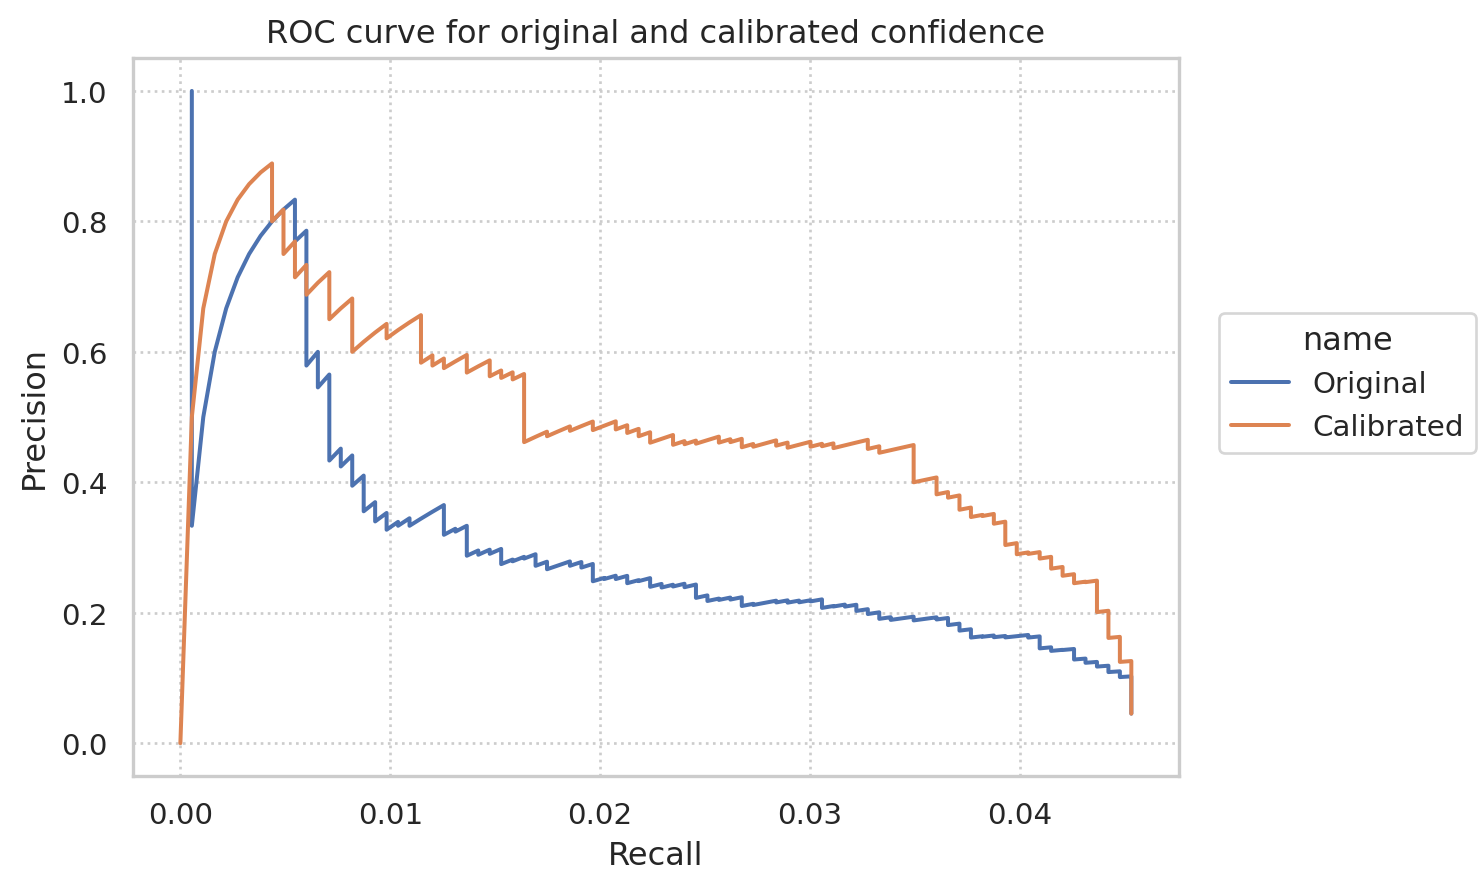

In [9]:
original = compute_roc_curve(
    input_dataset=test_dataset,
    confidence_column='confidence',
    label_column='correct',
    name='Original'
)
calibrated = compute_roc_curve(
    input_dataset=test_dataset,
    confidence_column='calibrated_confidence',
    label_column='correct',
    name='Calibrated'
)
metrics = pd.concat([original, calibrated], axis=0).reset_index(drop=True)
metrics['fdr'] = 1 - metrics['precision']

plot = so.Plot(metrics, x='recall', y='precision', color='name')
plot = plot.add(so.Line(), group='name')
plot = plot.theme(theme_dict)
plot = plot.label(y='Precision', x='Recall', title='ROC curve for original and calibrated confidence')
plot

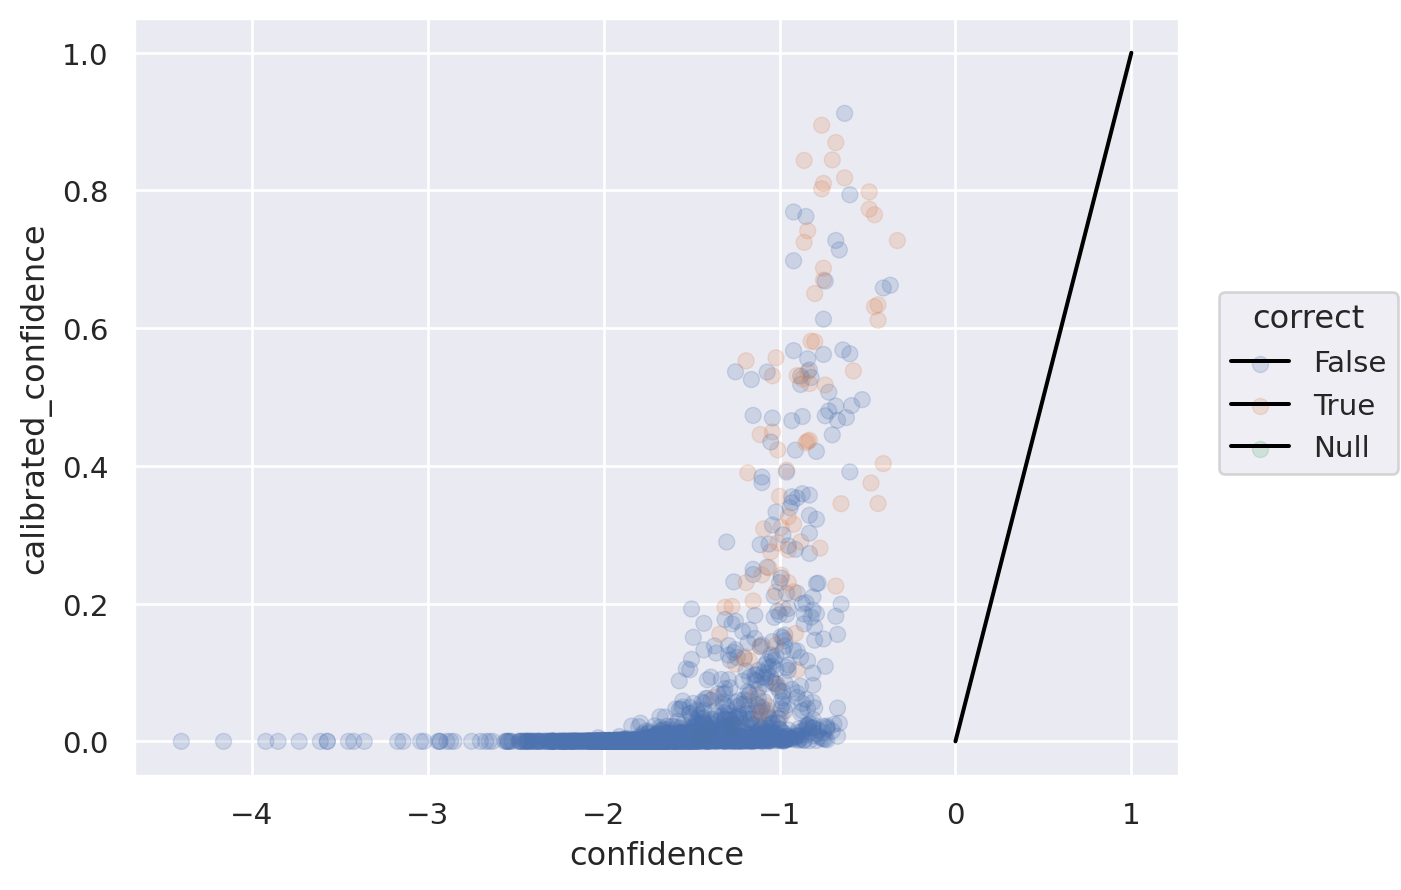

In [10]:
# TODO: quantify confidence shift
data = test_dataset.metadata[['confidence', 'calibrated_confidence', 'correct']].copy(deep=True)
data['correct'] = pd.Categorical(data['correct'])

so.Plot(
    data, x='confidence', y='calibrated_confidence', color='correct'
).add(
    so.Dot(alpha=0.2)
).add(
    so.Line(color='black', linestyle='-'),
    data=pd.DataFrame(
        {'confidence': [0., 1.], 'calibrated_confidence': [0., 1.], 'correct': ['Null', 'Null']}
    )
)

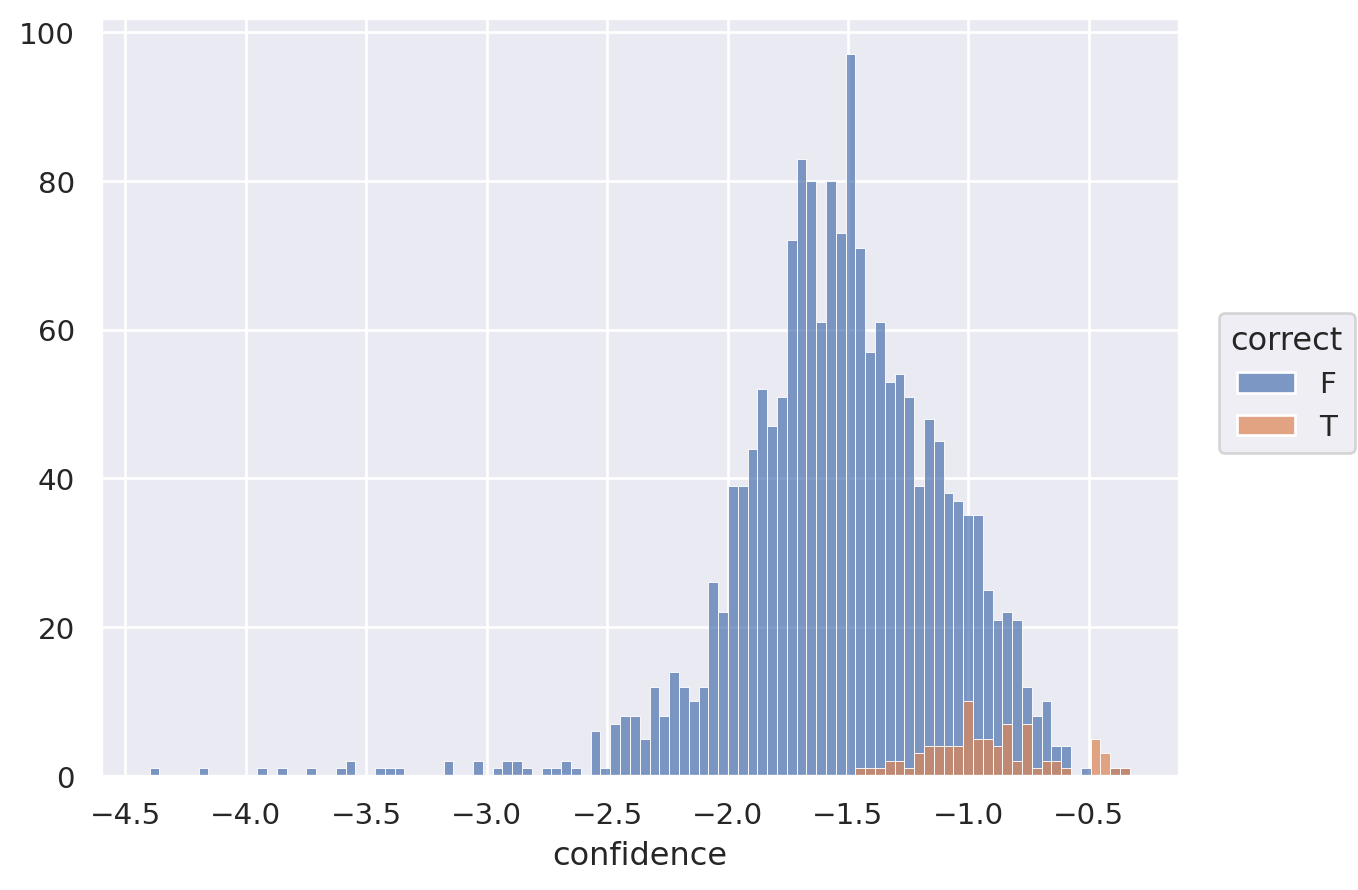

In [11]:
plot_df = test_dataset.metadata[['confidence', 'correct']].copy(deep=True)
plot_df['correct'] = plot_df['correct'].apply(lambda x: 'T' if x else 'F')
so.Plot(
    plot_df, 'confidence'
).add(
    so.Bars(), so.Hist(bins=100), color='correct'
)

In [12]:
plot_df[plot_df['confidence'] < 1e-1]

,confidence,correct
0,-2.25,F
1,-1.83,F
2,-1.27,F
3,-1.43,F
4,-1.22,F
...,...,...
1827,-1.66,F
1828,-1.75,F
1829,-0.85,F
1830,-1.87,F


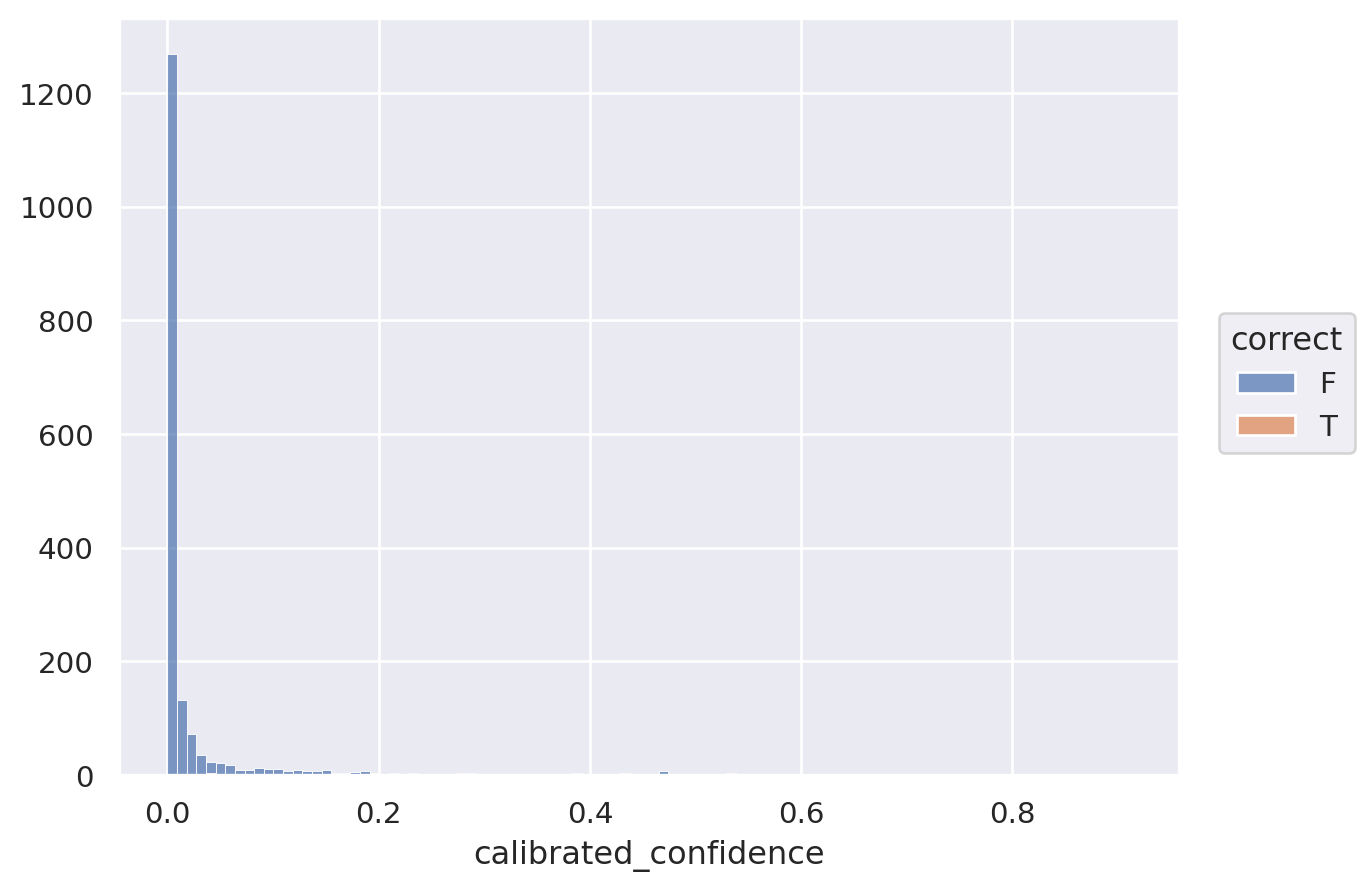

In [13]:
plot_df = test_dataset.metadata[['calibrated_confidence', 'correct']].copy(deep=True)
plot_df['correct'] = plot_df['correct'].apply(lambda x: 'T' if x else 'F')
so.Plot(
    plot_df, 'calibrated_confidence'
).add(
    so.Bars(), so.Hist(bins=100), color='correct'
)

In [14]:
plot_df[plot_df['calibrated_confidence'] < 1e-1]

,calibrated_confidence,correct
0,0.000089,F
1,0.000120,F
2,0.008997,F
3,0.001325,F
4,0.000321,F
...,...,...
1826,0.001398,F
1827,0.001173,F
1828,0.000359,F
1830,0.001099,F


In [15]:
database_grounded_fdr_control = DatabaseGroundedFDRControl()
database_grounded_fdr_control.fit(
    dataset=test_dataset.metadata, residue_masses=RESIDUE_MASSES
)

mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=test_dataset.metadata['confidence'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:02<00:00, 2198.42it/s, init loss: -12069.6465, avg. loss [4751-5000]: nan]


In [16]:
mixture_fdr_control.get_confidence_cutoff(threshold=0.05)

Array(nan, dtype=float32)

In [17]:
mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=test_dataset.metadata['calibrated_confidence'])
mixture_fdr_control.get_confidence_cutoff(threshold=0.05)

 26%|██▌       | 1298/5000 [00:00<00:01, 2087.69it/s, init loss: -3092.5911, avg. loss [1001-1250]: nan]

100%|██████████| 5000/5000 [00:02<00:00, 2335.29it/s, init loss: -3092.5911, avg. loss [4751-5000]: nan]


Array(nan, dtype=float32)